## Exercise 02 — Bar chart

Daily checker commits split by daytime segments for user accounts.

In [1]:
import pandas as pd
import sqlite3

DB_PATH = '../data/checking-logs.sqlite'
PERIOD_ORDER = ['night', 'morning', 'afternoon', 'evening']


In [2]:
with sqlite3.connect(DB_PATH) as connection:
    commits = pd.read_sql_query(
        """
        SELECT timestamp
        FROM checker
        WHERE uid LIKE 'user_%'
        """,
        connection,
        parse_dates=['timestamp'],
    )

commits.head()


,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


In [3]:
def categorize_daytime(hour: int) -> str:
    if 0 <= hour <= 3:
        return 'night'
    if 4 <= hour <= 9:
        return 'morning'
    if 10 <= hour <= 16:
        return 'afternoon'
    return 'evening'

commits['date'] = commits['timestamp'].dt.date
commits['period'] = commits['timestamp'].dt.hour.map(categorize_daytime)

daily_period = (
    commits
    .groupby(['date', 'period'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=PERIOD_ORDER, fill_value=0)
    .sort_index()
)
daily_period.head()


period,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25


<Axes: title={'center': 'Commits per day'}, xlabel='date', ylabel='commits'>

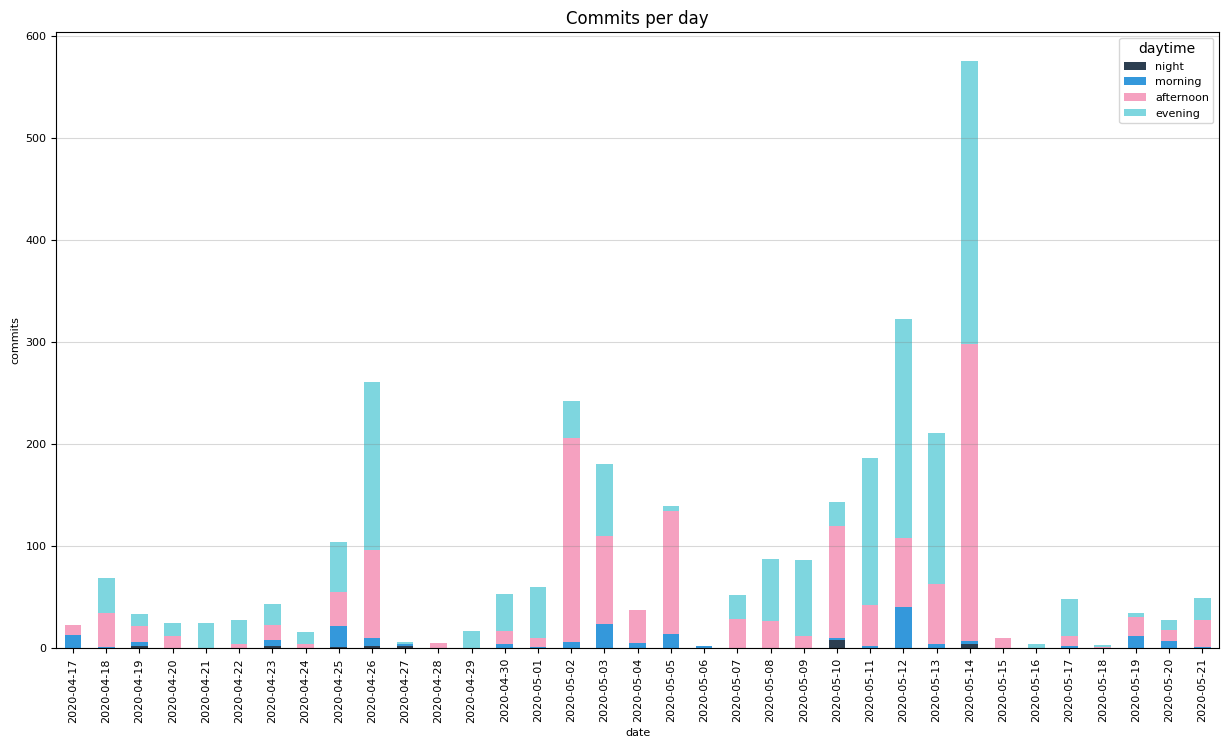

In [4]:
palette = ['#2c3e50', '#3498db', '#f5a1c0', '#7ed6df']
ax = daily_period.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 8),
    fontsize=8,
    color=palette,
    title='Commits per day',
)
ax.set_xlabel('date', fontsize=8)
ax.set_ylabel('commits', fontsize=8)
ax.tick_params(axis='x', labelrotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.legend(title='daytime', fontsize=8)
ax.grid(axis='y', color='gray', alpha=0.3)
ax


In [5]:
period_totals = daily_period.sum().sort_values(ascending=False)
top_periods = period_totals.index[:2].tolist()
evening_heavier = daily_period[daily_period['evening'] > daily_period['afternoon']]
evening_focus_date = evening_heavier.sum(axis=1).idxmax()
top_periods, period_totals, evening_focus_date


(['evening', 'afternoon'],
 period
 evening      1611
 afternoon    1391
 morning       184
 night          21
 dtype: int64,
 datetime.date(2020, 5, 12))

In [8]:
period_totals = daily_period.sum().sort_values(ascending=False)
most_common_periods = period_totals.head(2).index.tolist()
print(f"The two most common periods: {most_common_periods}")

The two most common periods: ['evening', 'afternoon']


In [10]:
daily_totals = daily_period.sum(axis=1)
condition = daily_period['evening'] > daily_period['afternoon']
filtered_days = daily_totals[condition]
target_date = filtered_days.idxmax()

print(f"Target date: {target_date}")

Target date: 2020-05-12


**When do our users usually commit to the labs: in the night, morning, afternoon, or evening?**  
The answer: evening and afternoon.

**Which day has the most number of commits while the evening count is higher than the afternoon count?**  
The answer: 2020-05-12.